In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/ANFIS-imgSatellitari')
%cd /content/drive/MyDrive/ANFIS-imgSatellitari/


# Import all the Libraries



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torch
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from training import train_model
from testMod import test_model
import anfis
from membership import *
from utility import load_model, plot_import, split_dataset
import cv2
import numpy as np
from skimage.filters.rank import entropy
from skimage.morphology import disk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


cpu
Begin training.


## **Model training**

In this phase a pixel dataset is used. This dataset is built from 10 images with annotated pixels in four classes: Building, Streets, Vegetation, Water.
To train the ANFIS network, the pixel information was extracted into a csv file. The information, for each pixel, is:
*   Red channel value;
*   Green channel value;
*   Blue channel value;
*   Entropy value;
*   Class to which the pixel belongs.

In practice, the values of the channels and entropy are the X, while the pixel class is the y of our supervised model. 

# The Dataset
The dataset of pixel was built from the [WHDLD dataset](https://sites.google.com/view/zhouwx/dataset?authuser=0#h.p_ebsAS1Bikmkd), a dense labeling dataset that contains about 5000 remote sensed images of the Wuhan area in China. Every image is also labeled in 6 classes as showed in this [picture](https://lh5.googleusercontent.com/BvMzGtJxgw6h4y6v7Ucv17rNYjYg0g8hBzMcJsh8DC7HQTGl-haGcShYeYx5TxLQOw4j5g0AksY33w7OPcKy8JQ7-JRZlriBGQDWcwQ8hOAqi9vQ=w1280).

For the purpose of our experiment, we can't use the entire dataset because our model requires in input only pixel values in numeric data. So, we decided to choose manually 10 images labeled in only 4 significant classes (the most informative): Building, Road, Vegetation, Water. We made this choice because classifying pixels only based on color and entropy value does not allow the model to easily distinguish similar classes (Builing and Bare Soil, for example).

So, the images we have chosen to extract the information mentioned above are the following.


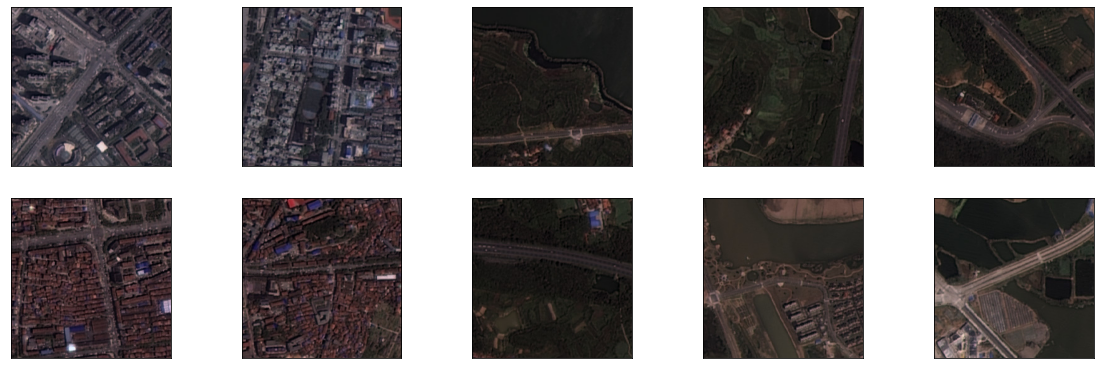

In [ ]:
images = []
for img_path in glob.glob('/content/drive/MyDrive/ANFIS-imgSatellitari/datasets/reduced4ClassV3/Images/*jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

We choose this set of images to have a "balanced" dataset, even if, as you can see, pixels noted as vegetation and building are the most present in many photos (also because all photos are taken in the area of a town). Next code show the dataset % composition in terms of pixel's classes.

In [ ]:
imagesPath = '/content/drive/MyDrive/ANFIS-imgSatellitari/datasets/reduced4ClassV3/Images'
labeledImagesPath = '/content/drive/MyDrive/ANFIS-imgSatellitari/datasets/reduced4ClassV3/ImagesPNG'
width = 256
height = 256

countBuilding = 0
countRoad = 0
countVegetation = 0
countWater = 0

imagesExt = '.jpg'
labelsExt = '.png'
i=0
# Opening file
fileImgs = open('/content/drive/MyDrive/ANFIS-imgSatellitari/datasets/reduced4ClassV3/labels.txt', 'r')
for line in fileImgs:
      imgName = line.strip()
      # read image
      img = cv2.imread(os.path.join(imagesPath, imgName + imagesExt), cv2.IMREAD_COLOR)
      # read segmented for labels
      imgLabs = (cv2.imread(os.path.join(labeledImagesPath, imgName + labelsExt), cv2.IMREAD_COLOR))

      for y in range(height):
          for x in range(width):
              # print(resized_img[y, x], end="\t")
              # pivel values from images
              pixel = img[y, x]
              blue = str(pixel[0])
              green = str(pixel[1])
              red = str(pixel[2])

              #pixel values from segmented "parallel" images
              pixelLab = imgLabs[y, x]
              blueLab = (pixelLab[0])
              greenLab = (pixelLab[1])
              redLab = (pixelLab[2])
              if redLab == 255 and greenLab == 0 and blueLab == 0:
                  label = 0 # building
                  countBuilding += 1
              elif (redLab == 255 and greenLab == 255 and blueLab == 0) \
                      or (redLab == 192 and greenLab == 192 and blueLab == 0):
                  label = 1  # road
                  countRoad += 1
              elif redLab == 0 and greenLab == 255 and blueLab == 0:
                  label = 2  # vegetation
                  countVegetation += 1
              else:
                  label = 3  # water
                  countWater += 1

# Closing files
fileImgs.close()

print("% Pixel per class: ")
print("Building ","{:.2f}".format((countBuilding/(countBuilding+countRoad+countVegetation+countWater))))
print("Road ", "{:.2f}".format(countRoad/(countBuilding+countRoad+countVegetation+countWater)))
print("Vegetation ", "{:.2f}".format(countVegetation/(countBuilding+countRoad+countVegetation+countWater)))
print("Water ", "{:.2f}".format(countWater/(countBuilding+countRoad+countVegetation+countWater)))


% Pixel per class: 
Building  0.22
Road  0.16
Vegetation  0.50
Water  0.12


# ANFIS training

Now, we are able to train our model with the pixel dataset. We choose 2 fuzzy sets for variable (as in the paper "*Opening the black box of neural networks for remote sensing image classification*"). We have 4 input variables (R,G,B and entropy), and 4 output variables (the classes to which the pixels belong).

We also use 32 of batch size and 20 epochs for the training of the neuro-fuzzy network. The Gaussian Function is used as membership function.

The code output shows the fuzzy rules extracted by the ANFIS and some metrics about the training and the test of the model.

In [ ]:
dataset = 'datasets/reduced4ClassV3/reducedV3.csv'
model = None
n_terms = 2 #IMPOSTA NUMERO DI FUZZY SET
batch_size = 32
num_categories = 4 #IMPOSTA NUMERO DI CLASSI
epoch = 20
model_l = False #SEMPRE A FALSE
hybrid = False #SEMPRE A FALSE
i = 0
lista_acc = []
k_fold = False

# Make the classes available via (controlled) reflection:
get_class_for = {n: globals()[n]
                 for n in ['BellMembFunc',
                           'GaussMembFunc',
                           'TriangularMembFunc',
                           'TrapezoidalMembFunc',
                           ]}

# DEFINIRE LA MEMBERSHIP FUNCTION ATTUALMENTE E' ABILITATA SOLO GAUSSIANA E TRIANGOLARE
membership_function = get_class_for['GaussMembFunc']

d_data, d_target = split_dataset(dataset)


# Split train into trainval-test
X_trainval, X_test, y_trainval, y_test = train_test_split(d_data, d_target, test_size=0.3, shuffle=True,
                                                          stratify=d_target, random_state=42)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, shuffle=True,
                                               stratify=y_trainval, random_state=42)


model = train_model(model, X_train, y_train, X_val, y_val, n_terms, num_categories,
                                   batch_size, epoch, model_l, hybrid, membership_function, i)

torch.save(model, 'models/G_model_geo_' + str(i) + '.h5')

model = torch.load('models/G_model_geo_0.h5')

test_model(model, X_test, y_test, num_categories, k_fold, i, lista_acc)

model = torch.load('models/G_model_geo_0.h5')

X_test = torch.Tensor(X_test)

y_pred = model(X_test)

cat_act = torch.argmax(y_pred, dim=1)

#PREDIZIONE SUI DATI DI TEST
print(cat_act)

cm = confusion_matrix(y_test, cat_act)
print(cm)

cl = classification_report(y_test, cat_act)
print(cl)





Model - Pre-training
AnfisNet(
  Rule  0: IF x0 is mf0 and x1 is mf0 and x2 is mf0 and x3 is mf0
           THEN [[0.0], [0.0], [0.0], [0.0]]
  Rule  1: IF x0 is mf0 and x1 is mf0 and x2 is mf0 and x3 is mf1
           THEN [[0.0], [0.0], [0.0], [0.0]]
  Rule  2: IF x0 is mf0 and x1 is mf0 and x2 is mf1 and x3 is mf0
           THEN [[0.0], [0.0], [0.0], [0.0]]
  Rule  3: IF x0 is mf0 and x1 is mf0 and x2 is mf1 and x3 is mf1
           THEN [[0.0], [0.0], [0.0], [0.0]]
  Rule  4: IF x0 is mf0 and x1 is mf1 and x2 is mf0 and x3 is mf0
           THEN [[0.0], [0.0], [0.0], [0.0]]
  Rule  5: IF x0 is mf0 and x1 is mf1 and x2 is mf0 and x3 is mf1
           THEN [[0.0], [0.0], [0.0], [0.0]]
  Rule  6: IF x0 is mf0 and x1 is mf1 and x2 is mf1 and x3 is mf0
           THEN [[0.0], [0.0], [0.0], [0.0]]
  Rule  7: IF x0 is mf0 and x1 is mf1 and x2 is mf1 and x3 is mf1
           THEN [[0.0], [0.0], [0.0], [0.0]]
  Rule  8: IF x0 is mf1 and x1 is mf0 and x2 is mf0 and x3 is mf0
           

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

best epoch 1
Epoch 001: | Train Loss: 0.79234869 | Val Loss: 0.74655511 | Train Acc: 0.65677446| Val Acc: 0.66744496
best epoch 2
Epoch 002: | Train Loss: 0.70189033 | Val Loss: 0.68850252 | Train Acc: 0.70611867| Val Acc: 0.70287283
best epoch 3
Epoch 003: | Train Loss: 0.65701054 | Val Loss: 0.65606450 | Train Acc: 0.73128433| Val Acc: 0.72535148
best epoch 4
Epoch 004: | Train Loss: 0.63368048 | Val Loss: 0.63935315 | Train Acc: 0.74234207| Val Acc: 0.73588333
best epoch 5
Epoch 005: | Train Loss: 0.62151197 | Val Loss: 0.62992398 | Train Acc: 0.74712399| Val Acc: 0.74093912
best epoch 6
Epoch 006: | Train Loss: 0.61425031 | Val Loss: 0.62379480 | Train Acc: 0.74982965| Val Acc: 0.74409432
best epoch 7
Epoch 007: | Train Loss: 0.60930838 | Val Loss: 0.61941413 | Train Acc: 0.75135550| Val Acc: 0.74605561
best epoch 8
Epoch 008: | Train Loss: 0.60568546 | Val Loss: 0.61613715 | Train Acc: 0.75239635| Val Acc: 0.74752659
best epoch 9
Epoch 009: | Train Loss: 0.60293169 | Val Loss: 0.6

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

RISULTATI TEST
147466 of 196608 correct (accuracy=75.01%)
tensor([3, 0, 3,  ..., 2, 2, 1])
[[26270  9085  6928     0]
 [ 5098 16320  9947   280]
 [ 3617  6655 86189  1947]
 [    1     0  5584 18687]]
              precision    recall  f1-score   support

         0.0       0.75      0.62      0.68     42283
         1.0       0.51      0.52      0.51     31645
         2.0       0.79      0.88      0.83     98408
         3.0       0.89      0.77      0.83     24272

    accuracy                           0.75    196608
   macro avg       0.74      0.70      0.71    196608
weighted avg       0.75      0.75      0.75    196608






# Test Images for the semantic segmentation

Now we can try our model for the classification of new images. Once we obtain the pixel's labels, we can tranform into images, which will describe a semantic segmentation of the input images. First we choose 3 images as example.

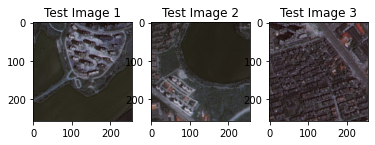

In [ ]:
img1path = '/content/drive/MyDrive/ANFIS-imgSatellitari/datasets/test/wh0108.jpg'
img2path = '/content/drive/MyDrive/ANFIS-imgSatellitari/datasets/test/wh0345.jpg'
img3path = '/content/drive/MyDrive/ANFIS-imgSatellitari/datasets/test/wh0496.jpg'

img1 = cv2.imread(img1path, cv2.IMREAD_COLOR)
img2 = cv2.imread(img2path, cv2.IMREAD_COLOR)
img3 = cv2.imread(img3path, cv2.IMREAD_COLOR)

f, axarr = plt.subplots(nrows=1,ncols=3)
plt.sca(axarr[0]); 
plt.imshow(img1); plt.title('Test Image 1')
plt.sca(axarr[1]); 
plt.imshow(img2); plt.title('Test Image 2')
plt.sca(axarr[2]); 
plt.imshow(img3); plt.title('Test Image 3')
plt.show()

Then, we have to extract the RGB values and our feature (the entropy).

In [ ]:

# getX extract pixel values and entropy from a given image
def getX(img):
  height = 256
  width = 256
  # initialize black image (it will be the segmented one)
  X = np.empty([65536, 4], dtype=float)
  i = 0 

  # black and white image for compute the entropy
  grayScaleImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgEntropy = entropy(grayScaleImg, disk(3))

  for y in range(height):
    for x in range(width):
      pixel = img[y, x]
      blueVal = float(pixel[0])
      greenVal = float(pixel[1])
      redVal = float(pixel[2])
      entropyVal = float(imgEntropy[y, x])

      values = np.array([redVal, greenVal, blueVal, entropyVal])
      X[i] = values
      i+=1

  return X

X1 = getX(img1)
X2 = getX(img2)
X3 = getX(img3)



At this point, we can perform the segmentation.
We choose the following colors for the segmentation:

1.   Red for the class Building;
2.   Yellow for the class Road;
3.   Green for the class Vegetation;
4.   Blue for the class Water.

In [ ]:
def getSegmentation(X):
  # classify the pixels
  X = torch.Tensor(X)
  y_vals = model(X)
  cat_y = torch.argmax(y_vals, dim=1)
  labels = cat_y.numpy()

  # now build the matrix of labels
  imgLabels = np.empty([256, 256], dtype=np.uint8)
  i = 0
  for y in range(256):
    for x in range(256):
      imgLabels[y, x] = labels[i]
      i += 1

  # now build the segmented image from the labels (REMEMBER MATPLOT USE RGB, BUT OPENCV BGR)
  segmentedImg = np.ones([256, 256, 3], dtype=np.uint8)
  build = 0
  road = 0
  vegetation = 0
  water = 0
  for y in range(256):
    for x in range(256):
      if imgLabels[y, x] == 0: # building -> red
        segmentedImg[y, x][0] = 255
        segmentedImg[y, x][1] = 0
        segmentedImg[y, x][2] = 0
        build  += 1
  
      elif imgLabels[y, x] == 1: # road -> yellow
        segmentedImg[y, x][0] = 255
        segmentedImg[y, x][1] = 255
        segmentedImg[y, x][2] = 0
        road += 1
  
      elif imgLabels[y, x] == 2: # vegetation -> green
        segmentedImg[y, x][0] = 0
        segmentedImg[y, x][1] = 255
        segmentedImg[y, x][2] = 0
        vegetation += 1
  
      else: # water -> blue
        segmentedImg[y, x][0] = 0
        segmentedImg[y, x][1] = 0
        segmentedImg[y, x][2] = 255
        water += 1

  return segmentedImg




Finally, we have the segmented images.
As we can see, our model performs well with the segmentetation of the water and vegetation area. By considering only RGB values and entropy is difficult to correct classify building and road pixels because they are very similar in therms of colors.

To increase the performance, multispectral images are required.

In [ ]:
segmentedImg1 = getSegmentation(X1)
segmentedImg2 = getSegmentation(X2)
segmentedImg3 = getSegmentation(X3)

f, axarr = plt.subplots(nrows=1,ncols=3)
plt.sca(axarr[0]); 
plt.imshow(segmentedImg1); plt.title('Test Image 1')
plt.sca(axarr[1]); 
plt.imshow(segmentedImg2); plt.title('Test Image 2')
plt.sca(axarr[2]); 
plt.imshow(segmentedImg3); plt.title('Test Image 3')
plt.show()

NameError: ignored